In [8]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.7.1" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


# Import thư viện

In [128]:
import Random: seed!
import LinearAlgebra: norm

# Initial populations Function

In [129]:
function rand_population_uniform(m, a, b)
    d = length(a)
    return [a+rand(d).*(b-a) for i in 1:m]
end

rand_population_uniform (generic function with 1 method)

# Selection Method

In [130]:
abstract type SelectionMethod end
struct TruncationSelection <: SelectionMethod
  k # top k to keep
end
function select(t::TruncationSelection, y)
  p = sortperm(y)
  return [p[rand(1:t.k, 2)] for i in y]
end

struct TournamentSelection <: SelectionMethod
  k
end
function select(t::TournamentSelection, y)
  getparent() = begin
    p = randperm(length(y))
    p[argmin(y[p[1:t.k]])]
  end
  return [[getparent(), getparent()] for i in y]
end

struct RouletteWheelSelection <: SelectionMethod end
function select(::RouletteWheelSelection, y)
  y = maximum(y) .- y
  cat = Categorical(normalize(y, 1))
  return [rand(cat, 2) for i in y]
end

select (generic function with 3 methods)

# Crossover Method


In [131]:
abstract type CrossoverMethod end
struct SinglePointCrossover <: CrossoverMethod end
function crossover(::SinglePointCrossover, a, b)
  i = rand(1:length(a))
  return vcat(a[1:i], b[i+1:end])
end

struct TwoPointCrossover <: CrossoverMethod end
  function crossover(::TwoPointCrossover, a, b)
  n = length(a)
  i, j = rand(1:n, 2)
  if i > j
    (i,j) = (j,i)
  end
  return vcat(a[1:i], b[i+1:j], a[j+1:n])
end

struct UniformCrossover <: CrossoverMethod end
function crossover(::UniformCrossover, a, b)
  child = copy(a)
  for i in 1 : length(a)
    if rand() < 0.5
      child[i] = b[i]
    end
  end
  return child
end

crossover (generic function with 3 methods)

# Mutation Method


In [132]:
abstract type MutationMethod end
struct BitwiseMutation <: MutationMethod
    λ
end
function mutate(M::BitwiseMutation, child)
    return [rand() < M.λ ? !v : v for v in child]
end
struct GaussianMutation <: MutationMethod
    σ
end
function mutate(M::GaussianMutation, child)
    return child + randn(length(child))*M.σ
end

mutate (generic function with 2 methods)

# Genetic Algorithm


In [214]:
populations = []

function genetic_algorithm(f, population, k_max, S, C, M)
      for k in 1 : k_max
        parents = select(S, f.(population))
        children = [crossover(C,population[p[1]],population[p[2]]) for p in parents]

        population .= mutate.(Ref(M), children)
    
        temp = []
     
        for p in population
            push!(temp, p)
        end
        push!(populations, temp)
        
      end
    population[argmin(f.(population))]
end

genetic_algorithm (generic function with 1 method)

# Test cho 2 biến

In [215]:
seed!(0) # set random seed for reproducible results


function ackley(x, a=20, b=0.2, c=2π)
    d = length(x)
    return -a*exp(-b*sqrt(sum(x.^2)/d)) -
    exp(sum(cos.(c*xi) for xi in x)/d) + a + exp(1)
end
f = x->ackley(x)
m = 100 # population size
k_max = 100 # number of iterations
population = rand_population_uniform(m, [1, 1], [6,6])

S = TruncationSelection(10) # select top 10
C = SinglePointCrossover()
M = GaussianMutation(0.5) # small mutation rate
x = genetic_algorithm(f, population, k_max, S, C, M)
println(x)


[-0.03828611507187096, -0.10973071540660234]


# Visualize for 2 variables

┌ Info: Saved animation to 
│   fn = /content/2gif.gif
└ @ Plots /root/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/content/2gif.gif")
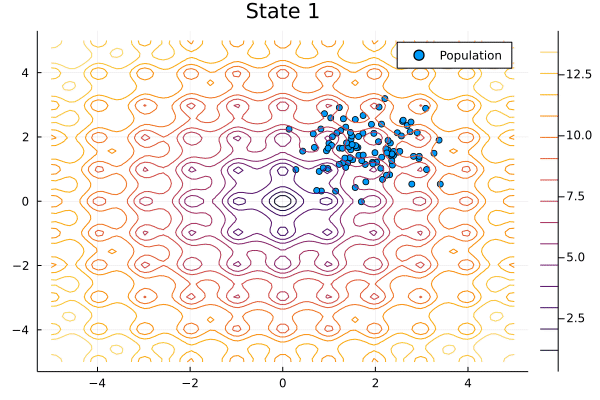

In [216]:
scatter_populations = []
xy = range(-5, 5, length=100)
for i in 1:length(populations)
    x = [p[1] for p in populations[i]]
    y = [p[2] for p in populations[i]]
    push!(scatter_populations, [scatter(x, y, title = "State " * string(i), label = "Population"),contour!(xy, xy, (a,b) -> f([a, b]))][1])
end
anim = @animate for i ∈ 1:length(populations) 
    plot(scatter_populations[i])
end
gif(anim, "2gif.gif", fps = 1)


# Test cho 1 biến

In [209]:
f = x->-exp(-x[1]^2)-2exp(-(x[1]-3)^2)
m = 100 # population size
k_max = 100 # number of iterations
population = rand_population_uniform(m, [-2], [4])
println(population)
S = TruncationSelection(10) # select top 10
C = SinglePointCrossover()
M = GaussianMutation(0.5) # small mutation rate
x = genetic_algorithm(f, population, k_max, S, C, M)
println(x)


[[1.5956506259412788], [3.478501524657225], [2.9529292558829514], [-0.015499462916929385], [-1.8332337371033247], [1.5348367390394042], [3.741418320500964], [3.693519192355364], [-0.8141421382894944], [-1.3447897694815705], [-0.5452223828083431], [3.313822983992905], [0.7761543097197348], [1.0943215725071331], [-0.4746599368556095], [0.1950064218716765], [-0.21146355417940632], [0.10669817456839947], [2.0475171636198954], [3.3526419361863375], [-1.4593161851903862], [3.223260564841281], [3.8795190984640877], [0.0907971081741259], [0.21709946211652253], [-0.20632364761583122], [-0.025268969464813607], [3.4732303887899834], [1.7247825830718355], [-1.641419092307729], [-1.1017400950812208], [-0.4798643706237795], [0.23054181128372342], [-1.4591642706327141], [-1.3632500443141908], [0.15445286184349882], [3.229289711149243], [-0.8398014716986981], [2.5275494654376294], [1.5045361427720017], [-1.3754764043287107], [-0.6637841963142486], [2.0852790413218525], [-0.2735180953302818], [2.471689

# Visualize for a variable


┌ Info: Saved animation to 
│   fn = /content/1gif.gif
└ @ Plots /root/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/content/1gif.gif")
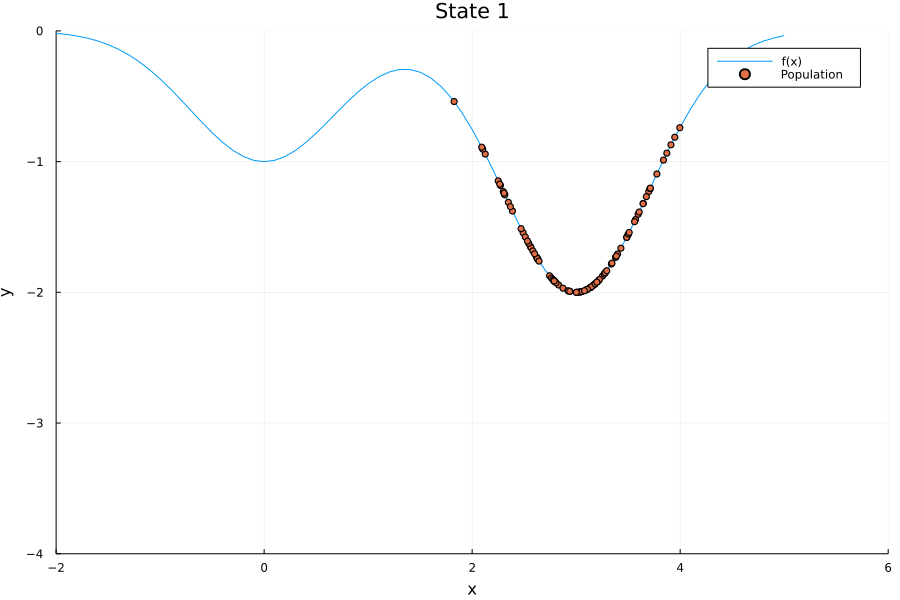

In [210]:
vis_plot = []
for i in 1:length(populations)
    x = [p[1] for p in populations[i]]
    y = [f(p[1]) for p in populations[i]]
    x_f = [-5 + i*0.1 for i in 1:100]
    y_f = [f(x) for x in x_f]
    push!(vis_plot,[plot(x_f,y_f, label = "f(x)"), 
    scatter!(x, y, title = "State " * string(i), label = "Population")][1])
end

anim = @animate for i ∈ 1:length(populations) 
    plot(vis_plot[i], size = (900, 600), xlim =  (-2,6), ylim = (-4,0), xlabel = "x", ylabel = "y")
end
gif(anim, "1gif.gif", fps = 1)